# Getting Sense of Data

In [1]:
import pandas as pd

file_path = 'combinedData_Exp1.csv'
df = pd.read_csv(file_path)
print(df.head())
print(df.shape)

FileNotFoundError: [Errno 2] No such file or directory: 'combinedData_Exp1.csv'

In [ ]:
df['sectionType'].value_counts()

,count
sectionType,
mainTask,33280
pracTask,5680
instructions,676
pracFeedback,450
blockBreak,195


In [ ]:
main_df = df[df['sectionType'] == 'mainTask']

In [ ]:
main_df.head(5)

,expStage,sectionType,block,blockType,trialCount,blockTrialCount,acc,RT,stimulus,stimCongruency,taskCue,switchType,partKey,stimOnset,respOnset,correct_resp,sectionStart,sectionEnd,sectionTime,subject
77,task,mainTask,1,B,1.0,1.0,1.0,952.0,1.0,i,m,n,109.0,410814.0,411766.0,109.0,NaN,NaN,NaN,Sub1
78,task,mainTask,1,B,2.0,2.0,1.0,938.0,2.0,c,m,r,109.0,413687.0,414625.0,109.0,NaN,NaN,NaN,Sub1
79,task,mainTask,1,B,3.0,3.0,1.0,748.0,1.0,i,p,s,122.0,416556.0,417304.0,122.0,NaN,NaN,NaN,Sub1
80,task,mainTask,1,B,4.0,4.0,1.0,966.0,3.0,i,m,s,109.0,419356.0,420322.0,109.0,NaN,NaN,NaN,Sub1
81,task,mainTask,1,B,5.0,5.0,1.0,848.0,6.0,i,m,r,122.0,422261.0,423109.0,122.0,NaN,NaN,NaN,Sub1


In [ ]:
main_df['acc'].value_counts()

,count
acc,
1.0,29740
0.0,3540


In [ ]:
main_df['trialCount'].value_counts()

,count
trialCount,
1.0,65
2.0,65
351.0,65
350.0,65
349.0,65
...,...
166.0,65
165.0,65
164.0,65


In [ ]:
main_df['stimCongruency'].value_counts()

,count
stimCongruency,
i,16640
c,16640


In [ ]:
main_df['taskCue'].value_counts() # p-parity, m-magnitude

,count
taskCue,
m,16640
p,16640


In [ ]:
main_df['switchType'].value_counts() #s-switch, r-repeat

,count
switchType,
r,16640
s,16380
n,260


In [ ]:
task_combos = pd.crosstab(main_df['switchType'], main_df['stimCongruency'])
task_combos

stimCongruency,c,i
switchType,,
n,134,126
r,8299,8341
s,8207,8173


In [ ]:
main_df.iloc[1000]

,1178
expStage,task
sectionType,mainTask
block,4
blockType,A
trialCount,489.0
blockTrialCount,105.0
acc,0.0
RT,717.0
stimulus,7.0
stimCongruency,i


In [ ]:
main_df['block'].value_counts()

,count
block,
1,8320
2,8320
3,8320
4,8320


# Creating Input Layer

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
import os
import matplotlib.pyplot as plt

In [ ]:
os.chdir('/content/drive/My Drive/CS 230: Deep Learning/stability-flexibility-tradeoff-master/Participant Data')
df_exp_1 = pd.read_csv('Experiment 1/combinedData_Exp1.csv')
!ls

'Experiment 1'	'Experiment 2'	'Experiment 3'


In [ ]:
# Filter the DataFrame to include only rows where expStage is 'task' and sectionType is 'mainTask'
df_exp_1_task = df_exp_1[(df_exp_1['expStage'] == 'task') & (df_exp_1['sectionType'] == 'mainTask')].copy()

# Add previous stimulus and taskCue columns
df_exp_1_task.loc[:, 'prev_stimulus'] = df_exp_1_task['stimulus'].shift(1)
df_exp_1_task.loc[:, 'prev_taskCue'] = df_exp_1_task['taskCue'].shift(1)


# Select only the useful columns
df_exp_1_input = df_exp_1_task[['stimulus', 'taskCue', 'prev_stimulus', 'stimCongruency', 'switchType', 'prev_taskCue', 'acc', 'RT']]
df_exp_1_input_acc_only = df_exp_1_input[df_exp_1_input['acc'] == 1]

# Remove any rows where switchType is n
df_exp_1_input_acc_only = df_exp_1_input_acc_only[df_exp_1_input_acc_only['switchType'] != 'n']


In [ ]:
df_exp_1_input_acc_only


,stimulus,taskCue,prev_stimulus,stimCongruency,switchType,prev_taskCue,acc,RT
78,2.0,m,1.0,c,r,m,1.0,938.0
79,1.0,p,2.0,i,s,m,1.0,748.0
80,3.0,m,1.0,i,s,p,1.0,966.0
81,6.0,m,3.0,i,r,m,1.0,848.0
82,3.0,p,6.0,i,s,m,1.0,1092.0
...,...,...,...,...,...,...,...,...
40276,7.0,p,4.0,i,s,m,1.0,726.0
40277,9.0,m,7.0,i,s,p,1.0,733.0
40278,6.0,p,9.0,c,s,m,1.0,622.0
40279,7.0,p,6.0,i,r,p,1.0,599.0


[link text](https://)# Linear Regression # Encode binary categorical vars as binary numerical
binary_cols = ['taskCue', 'stimCongruency', 'switchType', 'prev_taskCue']
binary_mapping = {'i': 1, 'c': 0, 'r': 0, 's': 1, 'p': 1, 'm': 0}

for col in binary_cols:
    X[col] = X[col].map(binary_mapping)

In [ ]:
features = ['stimulus', 'taskCue', 'prev_stimulus', 'stimCongruency', 'switchType', 'prev_taskCue']
target = 'RT'

X = df_exp_1_input_acc_only[features].copy()
y = df_exp_1_input_acc_only[target].values

# Encode binary categorical vars as binary numerical
binary_cols = ['taskCue', 'stimCongruency', 'switchType', 'prev_taskCue']
binary_mapping = {'i': 0, 'c': 1, 'r': 0, 's': 1, 'p': 1, 'm': 0}

for col in binary_cols:
    X[col] = X[col].map(binary_mapping)


X = X.values.astype(np.float32)
y = y.astype(np.float32)/1000

# Split the data into training and test sets that are nunpy arrays
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.01, random_state=42)

X_train


array([[7., 0., 2., 0., 0., 0.],
       [2., 1., 7., 1., 0., 1.],
       [1., 0., 2., 0., 1., 1.],
       ...,
       [8., 0., 4., 1., 0., 0.],
       [1., 1., 3., 1., 1., 0.],
       [1., 0., 8., 1., 1., 1.]], dtype=float32)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(np.array(X_train))
X_test_tensor = torch.tensor(np.array(X_test))
y_train_tensor = torch.tensor(np.array(y_train)).unsqueeze(1)
y_test_tensor = torch.tensor(np.array(y_test)).unsqueeze(1)

# Check for NaNs or Infs in target data
print(torch.isnan(X_train_tensor).any())
print(torch.isinf(X_train_tensor).any())

print(torch.isnan(y_train_tensor).any())
print(torch.isinf(y_train_tensor).any())

X_train

tensor(False)
tensor(False)
tensor(False)
tensor(False)


array([[7., 0., 2., 0., 0., 0.],
       [2., 1., 7., 1., 0., 1.],
       [1., 0., 2., 0., 1., 1.],
       ...,
       [8., 0., 4., 1., 0., 0.],
       [1., 1., 3., 1., 1., 0.],
       [1., 0., 8., 1., 1., 1.]], dtype=float32)

In [ ]:
class LinearRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LinearRegressionModel, self).__init__()
        self.linear = nn.Linear(input_dim, 1)

    def forward(self, x):
        return self.linear(x)

# Define the input dimension
input_dim = X_train_tensor.shape[1]
input_dim

# Instantiate the model, loss function, and optimizer
model = LinearRegressionModel(input_dim)
criterion = nn.MSELoss()
optimizer = optim.SGD(model.parameters(), lr=0.01)

In [ ]:
# Training the linear regression model
num_epochs = 1000
train_losses = []

for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()  # Clear the gradients

    # Forward pass
    y_pred = model(X_train_tensor)
    print(y_pred)
    loss = criterion(y_pred, y_train_tensor)

    # Backward pass and optimization
    loss.backward()
    optimizer.step()

    # Record the training loss
    train_losses.append(loss.item())

    if (epoch + 1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Convert loss to numpy array for easy plotting
train_losses = np.array(train_losses)

Streaming output truncated to the last 5000 lines.
        [0.8067]], grad_fn=<AddmmBackward0>)
tensor([[0.6276],
        [0.7457],
        [0.7146],
        ...,
        [0.6563],
        [0.7680],
        [0.8069]], grad_fn=<AddmmBackward0>)
tensor([[0.6278],
        [0.7457],
        [0.7149],
        ...,
        [0.6565],
        [0.7680],
        [0.8071]], grad_fn=<AddmmBackward0>)
tensor([[0.6281],
        [0.7458],
        [0.7152],
        ...,
        [0.6567],
        [0.7680],
        [0.8073]], grad_fn=<AddmmBackward0>)
tensor([[0.6283],
        [0.7458],
        [0.7155],
        ...,
        [0.6569],
        [0.7680],
        [0.8074]], grad_fn=<AddmmBackward0>)
tensor([[0.6286],
        [0.7458],
        [0.7158],
        ...,
        [0.6571],
        [0.7680],
        [0.8076]], grad_fn=<AddmmBackward0>)
tensor([[0.6288],
        [0.7459],
        [0.7161],
        ...,
        [0.6573],
        [0.7681],
        [0.8078]], grad_fn=<AddmmBackward0>)
tensor([[0.6291]

Test Loss: 0.0479


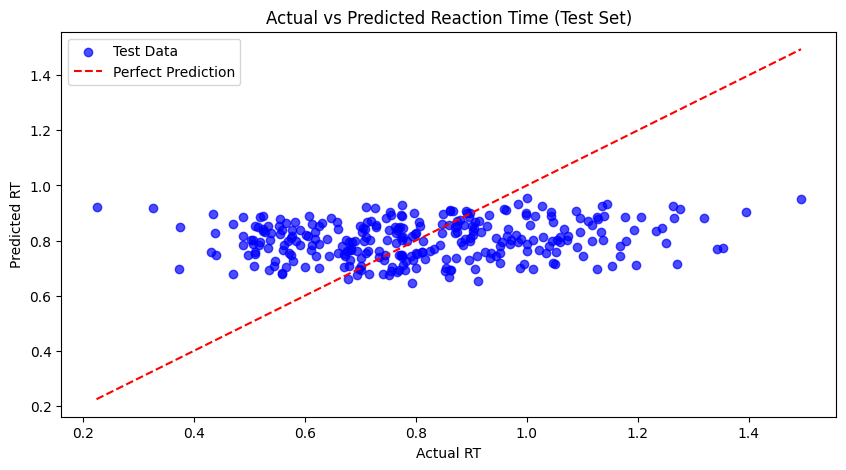

In [ ]:
# Evaluation on the test set
model.eval()
with torch.no_grad():
    y_pred_test = model(X_test_tensor)
    test_loss = criterion(y_pred_test, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

    # Plotting the predictions vs actual values for the test set
    plt.figure(figsize=(10, 5))
    plt.scatter(y_test_tensor.numpy(), y_pred_test.numpy(), label='Test Data', alpha=0.7, color='blue')
    plt.plot([min(y_test_tensor.numpy()), max(y_test_tensor.numpy())],
             [min(y_test_tensor.numpy()), max(y_test_tensor.numpy())],
             color='red', linestyle='--', label='Perfect Prediction')
    plt.xlabel('Actual RT')
    plt.ylabel('Predicted RT')
    plt.legend()
    plt.title('Actual vs Predicted Reaction Time (Test Set)')
    plt.show()

# LSTM Model #1

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np

In [ ]:
# Selecting relevant features and target
features = ['stimulus', 'taskCue', 'prev_stimulus', 'prev_taskCue', 'stimCongruency', 'switchType']
target = 'RT'

In [ ]:
# Divide into input and output
X = df_exp_1_input_acc_only[features].copy()
y = df_exp_1_input_acc_only[target].values

# Identify numeric and categorical columns
numeric_cols = X.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = X.select_dtypes(exclude=['float64', 'int64']).columns

# One-hot encode categorical columns
X_encoded = pd.get_dummies(X, columns=categorical_cols)


,stimulus,prev_stimulus,taskCue_m,taskCue_p,prev_taskCue_m,prev_taskCue_p,stimCongruency_c,stimCongruency_i,switchType_n,switchType_r,switchType_s
77,-1.457160,NaN,True,False,False,False,False,True,True,False,False
78,-1.092941,-1.459909,True,False,True,False,True,False,False,True,False
79,-1.457160,-1.095297,False,True,True,False,False,True,False,False,True
80,-0.728721,-1.459909,True,False,False,True,False,True,False,False,True
81,0.363938,-0.730684,True,False,True,False,False,True,False,True,False
...,...,...,...,...,...,...,...,...,...,...,...
40276,0.728158,-0.366072,False,True,True,False,False,True,False,False,True
40277,1.456597,0.727766,True,False,False,True,False,True,False,False,True
40278,0.363938,1.456991,False,True,True,False,True,False,False,False,True
40279,0.728158,0.363154,False,True,False,True,False,True,False,True,False


In [ ]:
# Normalize features
scaler = StandardScaler()
X_encoded[numeric_cols] = scaler.fit_transform(X_encoded[numeric_cols])

# Ensure data is in float32 format for PyTorch
X_processed = X_encoded.values.astype(np.float32)
y_processed = y.astype(np.float32)


In [ ]:
# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y_processed, test_size=0.2, random_state=42)

X_train


array([[-1.0929406 ,  0.7277661 ,  1.        , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.4565969 ,  0.7277661 ,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [-0.72872096, -1.4599092 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       ...,
       [-0.3645013 ,  0.7277661 ,  0.        , ...,  0.        ,
         1.        ,  0.        ],
       [-1.4571602 , -0.36607155,  0.        , ...,  0.        ,
         0.        ,  1.        ],
       [ 0.7281576 , -0.36607155,  1.        , ...,  0.        ,
         0.        ,  1.        ]], dtype=float32)

In [ ]:
# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)  # Add time dimension if needed
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)    # Add time dimension if needed
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

print(X_train_tensor.shape, X_test_tensor.shape, y_train_tensor.shape, y_test_tensor.shape)


torch.Size([23792, 11]) torch.Size([5948, 11]) torch.Size([23792]) torch.Size([5948])


In [ ]:
# Define the LSTM Model
class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        out, _ = self.lstm(x, (h0, c0))
        out = self.fc(out[:, -1, :])
        return out

In [ ]:
# Define model, loss function and optimizer
input_dim = X_train.shape[1]
hidden_dim = 64
output_dim = 1
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

class LSTMModel(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, num_layers):
        super(LSTMModel, self).__init__()
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # Initialize hidden state and cell state (h0, c0) to zeros
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_dim).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        return out

# Define model, loss function, and optimizer
input_dim = X_train_tensor.shape[1]
hidden_dim = 64
output_dim = 1
num_layers = 2

model = LSTMModel(input_dim, hidden_dim, output_dim, num_layers)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Ensure the input tensor is of shape (batch_size, seq_len, input_dim)
if len(X_train_tensor.shape) == 2:
    X_train_tensor = X_train_tensor.unsqueeze(1)  # Add time dimension
if len(X_test_tensor.shape) == 2:
    X_test_tensor = X_test_tensor.unsqueeze(1)  # Add time dimension

# Training loop
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        # Forward pass
        output = model(X_batch)
        loss = criterion(output, y_batch)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}')

# Evaluation
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor)
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item()}')

In [ ]:
# Train the model
num_epochs = 100
batch_size = 32

for epoch in range(num_epochs):
    model.train()
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        output = model(X_batch)
        loss = criterion(output, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


In [ ]:
# Evaluate the model
model.eval()
with torch.no_grad():
    y_pred = model(X_test_tensor).squeeze()
    test_loss = criterion(y_pred, y_test_tensor)
    print(f'Test Loss: {test_loss.item():.4f}')

# Example: converting predictions to numpy
y_pred_np = y_pred.numpy()



```
# This is formatted as code
```

# Distribution of PracTask and GRU

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import ks_2samp
from google.colab import drive
from sklearn.model_selection import train_test_split
import tensorflow as tf
import keras
from keras import layers
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import SimpleRNN
from keras.layers import Dropout
from keras.layers import GRU, Bidirectional
from keras.optimizers import SGD
from keras.optimizers import Adam
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
drive.mount('/content/drive/')
##!ls "/content/drive/My Drive/"

import pandas as pd
file_path = '/content/drive/My Drive/ParticipantData.csv'  # Replace 'your_file.csv' with the actual path to your file
df_Experiment1 = pd.read_csv(file_path)

print(df_Experiment1)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
      expStage   sectionType  block blockType  trialCount  blockTrialCount  \
0      prac1-1  instructions      1       NaN         NaN              NaN   
1      prac1-2  instructions      1       NaN         NaN              NaN   
2         task      pracTask      1       NaN         1.0              1.0   
3         task      pracTask      1       NaN         2.0              2.0   
4         task      pracTask      1       NaN         3.0              3.0   
...        ...           ...    ...       ...         ...              ...   
40276     task      mainTask      4         B       508.0            124.0   
40277     task      mainTask      4         B       509.0            125.0   
40278     task      mainTask      4         B       510.0            126.0   
40279     task      mainTask      4         B       511.0            127.0   
40280     t

# Following function helps understand and visualise some elements of our  training data like response time patterns for conguency and repeatability effects

In [ ]:
def lets_understand_data(all_data):

  # Filtering All accurate data in the dataframe
  # This automatically filters instructions, pracFeedback, blockBreak in the sectionType columns
  df_Experiment1_acc = df_Experiment1[(df_Experiment1['acc'] == 1)]
  print(len(df_Experiment1_acc))

    # Filtering Only subject 1 accurate data for visualisation purposes
  df_Experiment1_Sub1 = df_Experiment1[(df_Experiment1['subject'] == "Sub1") & (df_Experiment1['acc'] == 1)]
  print(len(df_Experiment1_Sub1))

    # Understanding response times for congruent and incongruent tasks
  df_Experiment1_Sub1_cong =  df_Experiment1_Sub1.loc[df_Experiment1_Sub1['stimCongruency'] == 'c' , 'RT']
  df_Experiment1_Sub1_incong =  df_Experiment1_Sub1.loc[df_Experiment1_Sub1['stimCongruency'] == 'i' , 'RT']

  figure, axis = plt.subplots(2, 2)

  axis[0, 0].plot(df_Experiment1_Sub1_cong)
  axis[0, 0].plot(df_Experiment1_Sub1_incong)
  axis[0, 0].legend(['Congruent','Incongruent'])
  axis[0, 0].set_title('Comparison of Response times for Congruent/Incongruent stimuli and Repeat/Non-repeat stimuli')

  axis[0, 1].hist(df_Experiment1_Sub1_cong, color = 'blue', edgecolor = 'black')
  axis[0, 1].hist(df_Experiment1_Sub1_incong, color = 'red', edgecolor = 'black')
  axis[0, 1].legend(['Congruent','Incongruent'])

  # Understanding response times for Repeat and Not-repeat tasks
  df_Experiment1_Sub1_repeat =  df_Experiment1_Sub1.loc[df_Experiment1_Sub1['switchType'] == 'r' , 'RT']
  df_Experiment1_Sub1_nonrepeat =  df_Experiment1_Sub1.loc[df_Experiment1_Sub1['switchType'] == 's' , 'RT']

  axis[1, 0].plot(df_Experiment1_Sub1_repeat)
  axis[1, 0].plot(df_Experiment1_Sub1_nonrepeat)
  axis[1, 0].legend(['Repeat task','Non-repeat task'])

  axis[1, 1].hist(df_Experiment1_Sub1_repeat, color = 'blue', edgecolor = 'black')
  axis[1, 1].hist(df_Experiment1_Sub1_nonrepeat, color = 'red', edgecolor = 'black')
  axis[1, 1].legend(['Repeat task','Non-repeat task'])

  return df_Experiment1_acc

33873
547
33873


array(['pracTask', 'mainTask'], dtype=object)

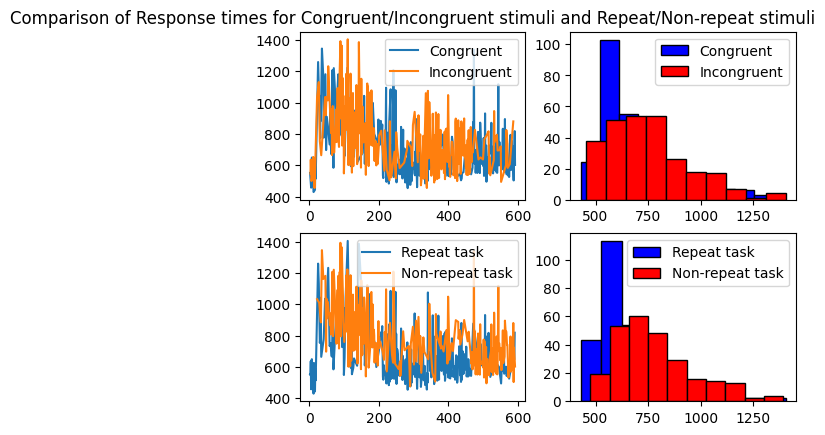

In [ ]:
df_Experiment1_acc = lets_understand_data(df_Experiment1)
print(len(df_Experiment1_acc))

pd.unique(df_Experiment1_acc["sectionType"])

#Lets understand which input features are important for training

###1. Checking if Practice Task data can be utilised accross samples. we have utilised KS test to check the same


In [ ]:
# Comparing Practice Task data to understand if it can be used as input data to model
x = np.mean(df_Experiment1_acc.loc[df_Experiment1_acc['sectionType'] == "pracTask", 'RT'])
y = np.mean(df_Experiment1_acc.loc[df_Experiment1_acc['sectionType'] == "mainTask",'RT'])
print("Average value of Response Time for Practice Task across subjects :", x)
print("Average value of Response Time for Main Task across subjects :", y)

x_var = np.var(df_Experiment1_acc.loc[df_Experiment1_acc['sectionType'] == "pracTask", 'RT'])
y_var = np.var(df_Experiment1_acc.loc[df_Experiment1_acc['sectionType'] == "mainTask",'RT'])
print("Variance of Response Time for Practice Task across subjects :", x_var)
print("Variance of Response Time for Main Task across subjects :", y_var)
# plt.plot(x, y)
# plt.show()


# Perform the KS test - Comparing sample distributions with the Kolmogorov-Smirnov (KS) test
statistic, p_value = ks_2samp(df_Experiment1_acc.loc[df_Experiment1_acc['sectionType'] == "pracTask", 'RT'], df_Experiment1_acc.loc[df_Experiment1_acc['sectionType'] == "mainTask", 'RT'])

#The KS statistic, representing the maximum distance between the two cumulative distribution functions.
print("KS statistic:", statistic)

#If Pvalue is lesser than 0.05, we accept the hypothesis that both Practice and Main task are similar distribution and we can utilise practice task data for training
print("p-value:", p_value)

Average value of Response Time for Practice Task across subjects : 847.9910476651343
Average value of Response Time for Main Task across subjects : 819.7769334229994
Variance of Response Time for Practice Task across subjects : 69409.0221797154
Variance of Response Time for Main Task across subjects : 49167.294693218755
KS statistic: 0.08749161008439788
p-value: 1.2799683145958804e-24


###2. Performing Data Prep for training the model

Prev columns are not used in this model


In [ ]:
def Experiment_data_treatment(df_Experiment1_acc):

  # Missing data treatment needed for missing RT values

  # For each subject
  # We have 32 blocks of data
  print("Unique Blocks of data:", pd.unique(df_Experiment1_acc["block"]))
  # 4 Blocktypes
  print("Unique Blocktypes of data:", pd.unique(df_Experiment1_acc["blockType"]))
  # 128 Trials count
  print("Unique Trials of data:",pd.unique(df_Experiment1_acc["blockTrialCount"]))

  # Remove any rows where switchType is n
  df_Experiment1_acc = df_Experiment1_acc[df_Experiment1_acc['switchType'] != 'n']

  features = ['stimulus', 'taskCue', 'stimCongruency', 'switchType']
  target = 'RT'

  X = df_Experiment1_acc[features].copy()
  y = df_Experiment1_acc[target].values

  # Encode binary categorical vars as binary numerical
  binary_cols = ['taskCue', 'stimCongruency', 'switchType']
  binary_mapping = {'i': 0, 'c': 1, 'r': 0, 's': 1, 'p': 1, 'm': 0}

  for col in binary_cols:
     X[col] = X[col].map(binary_mapping)

  X = X.values.astype(np.float32)
  y = y.astype(np.float32)/1000

  # Split the data into training and test sets that are nunpy arrays
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

  X_train

  return X,y,X_train, X_test, y_train, y_test

In [ ]:
X, y, X_train, X_test, y_train, y_test = Experiment_data_treatment(df_Experiment1_acc)

Unique Blocks of data: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32]
Unique Blocktypes of data: [nan 'B' 'C' 'A' 'D']
Unique Trials of data: [  2.   3.   4.   5.   6.   7.   8.   1.  10.  11.  12.  13.  14.  16.
   9.  15.  17.  18.  19.  20.  22.  23.  24.  25.  26.  27.  29.  30.
  31.  32.  33.  34.  35.  36.  37.  38.  39.  41.  42.  43.  44.  45.
  46.  47.  48.  49.  50.  51.  52.  53.  54.  55.  56.  57.  58.  59.
  60.  61.  62.  63.  64.  65.  66.  67.  69.  70.  72.  73.  74.  75.
  76.  77.  78.  79.  80.  81.  82.  83.  84.  85.  86.  87.  88.  89.
  91.  92.  93.  94.  95.  96.  97.  98. 100. 101. 102. 103. 104. 105.
 106. 107. 108. 110. 111. 112. 113. 114. 115. 116. 117. 118. 119. 120.
 121. 122. 123. 124. 125. 126. 127. 128.  21.  28.  40.  68.  71.  90.
  99. 109.]


In [ ]:
#Initialising the model
regressorGRU = Sequential()

# GRU layers with Dropout regularisation
regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     input_shape=(X_train.shape[1],1),
                     activation='tanh'))
regressorGRU.add(Dropout(0.2))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     return_sequences=True,
                     activation='tanh'))

regressorGRU.add(GRU(units=50,
                     activation='tanh'))

# The output layer
regressorGRU.add(Dense(units=1,
                       activation='relu'))
# Compiling the RNN
regressorGRU.compile(optimizer=SGD(learning_rate=0.01,
                                   decay=1e-7,
                                   momentum=0.9,
                                   nesterov=False),
                     loss='mean_squared_error')

# Fitting the data
regressorGRU.fit(X_train,y_train,epochs=20,batch_size=1)
regressorGRU.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:33: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


Epoch 1/20
24386/30041 ━━━━━━━━━━━━━━━━━━━━ 45s 8ms/step - loss: 0.0578

In [ ]:
# predictions with X_test data
y_RNN = regressorGRU.predict(X_test)

y_train_check = pd.DataFrame(y_train * 1000)
y_test_check = pd.DataFrame(y_test * 1000)
y_RNN_check = pd.DataFrame(y_RNN * 1000)

#Plot for RNN predictions
plt.plot(y_train_check[10:], label = "train_data", color = "b")
plt.plot(y_test_check[10:], label = "test_data", color = "g")
plt.plot(y_test_check[10:], y_RNN_check[10:], label = "y_RNN", color = "brown")
plt.legend()